In [1]:
import logging
import pickle
import numpy as np
from openmmtools.integrators import PeriodicNonequilibriumIntegrator
from simtk import unit, openmm
import argparse
import os
import time
import mdtraj as md
from tqdm import tqdm
from openmmtools.constants import kB

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)



In [27]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/14/64/"
phase = 'complex'
sim_number = 2
old_aa_name = 'asn'
new_aa_name = 'lys'
length = 1
cache = 1
cache_length = 1

## Run vanilla MD

In [13]:
# from perses.annihilation.rest import RESTTopologyFactory

In [11]:
# with open("/data/chodera/zhangi/perses_benchmark/neq/14/64/64_complex_0.pickle", "rb") as f:
#     rhtf = pickle.load(f)

In [14]:
# # Build REST factory
# for res in rhtf.hybrid_topology.residues:
#     if res.resSeq == 501 and res.chain.index == 0:
#         mutated_res = res
# query_indices = [atom.index for atom in mutated_res.atoms]
# traj = md.Trajectory(np.array(rhtf.hybrid_positions), rhtf.hybrid_topology)
# solute_atoms = list(traj.topology.select("is_protein"))
# rest_atoms = list(md.compute_neighbors(traj, 0.5, query_indices, haystack_indices=solute_atoms)[0])
# factory = RESTTopologyFactory(rhtf.hybrid_system, solute_region=rest_atoms, use_dispersion_correction=True)

# # Get REST system
# REST_system = factory.REST_system

<ipython-input-14-a96e2261c163>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rest_atoms = list(md.compute_neighbors(traj, 0.5, query_indices, haystack_indices=solute_atoms)[0])
INFO:REST:Added MonteCarloBarostat.
INFO:REST:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=13.804333500000002, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-4.601444128722184, y=13.014850568080696, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-4.601444128722184, y=-6.507424496441187, z=11.271191673136768), unit=nanometer)]
INFO:REST:N

In [3]:
i = os.path.basename(os.path.dirname(outdir))
with open(os.path.join("/data/chodera/zhangi/perses_benchmark/neq/15/64/", f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [3]:
# with open("rest_system.pickle", "rb") as f:
#     REST_system = pickle.load(f)

In [28]:
# Read in lambda = 0 cache
i = os.path.basename(os.path.dirname(outdir))
with open(os.path.join(outdir, f"{i}_{phase}_{old_aa_name}_{cache_length}ns_snapshots.npy"), 'rb') as f:
    subset_pos = np.load(f)
positions = subset_pos[sim_number]
system = htf.hybrid_system
# system = REST_system


In [53]:
# with open("rest_system.pickle", "wb") as f:
#     pickle.dump(REST_system, f)

In [29]:
from openmmtools.integrators import LangevinIntegrator
from perses.tests.utils import compute_potential_components

# Define simulation parameters
temperature = 298 * unit.kelvin
collision_rate = 1.0 / unit.picoseconds
nsteps = 10000
timestep = 1.0 * unit.femtosecond
platform_name = 'CUDA'
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

kT = kB * temperature
beta = 1.0/kT

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')
context = openmm.Context(system, integrator, platform)
context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)

# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [30]:
all_old = []
pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
old_pos = np.asarray(htf.old_positions(pos))
all_old.append(old_pos)

In [31]:
# Run equilibration
for step in range(10):
    integrator.step(1)
    pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    old_pos = np.asarray(htf.old_positions(pos))
    all_old.append(old_pos)
#     _logger.info(f'forward NEQ step: {step}, potential energy: {compute_potential_components(context, beta=beta)}')
    _logger.info(f'forward NEQ step: {step}, potential energy: {context.getState(getEnergy=True).getPotentialEnergy()}')

    

INFO:root:forward NEQ step: 0, potential energy: -3010600.997488915 kJ/mol
INFO:root:forward NEQ step: 1, potential energy: -3003755.7059053485 kJ/mol
INFO:root:forward NEQ step: 2, potential energy: -2993593.2367925267 kJ/mol
INFO:root:forward NEQ step: 3, potential energy: -2981503.035334979 kJ/mol
INFO:root:forward NEQ step: 4, potential energy: -2968707.204942686 kJ/mol
INFO:root:forward NEQ step: 5, potential energy: -2955884.8905473133 kJ/mol
INFO:root:forward NEQ step: 6, potential energy: -2943094.948810193 kJ/mol
INFO:root:forward NEQ step: 7, potential energy: -2929960.1110249846 kJ/mol
INFO:root:forward NEQ step: 8, potential energy: -2916019.4176000566 kJ/mol
INFO:root:forward NEQ step: 9, potential energy: -2901078.965843988 kJ/mol


In [37]:
old_traj = md.Trajectory(all_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))

In [38]:
old_traj[0].save(f"check_{sim_number}_min.pdb")

In [39]:
old_traj.save(f"check_{sim_number}_min.dcd")

In [57]:
from openmmtools.integrators import LangevinIntegrator
from perses.tests.utils import compute_potential_components

# Define simulation parameters
temperature = 298 * unit.kelvin
collision_rate = 1.0 / unit.picoseconds
nsteps = 10000
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
integrator = LangevinIntegrator(temperature, collision_rate, timestep)

kT = kB * temperature
beta = 1.0/kT

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')
context = openmm.Context(system, integrator, platform)
context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(pos)
context.setVelocitiesToTemperature(temperature)


In [58]:
# Run equilibration
for step in range(nsteps):
    integrator.step(1)
#     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     old_pos = np.asarray(htf.old_positions(pos))
#     all_old.append(old_pos)
#     _logger.info(f'forward NEQ step: {step}, potential energy: {compute_potential_components(context, beta=beta)}')
    _logger.info(f'forward NEQ step: {step}, potential energy: {context.getState(getEnergy=True).getPotentialEnergy()}')

    

INFO:root:forward NEQ step: 0, potential energy: -1183701.2345888861 kJ/mol
INFO:root:forward NEQ step: 1, potential energy: 18923334727.93588 kJ/mol


OpenMMException: Error invoking kernel: CUDA_ERROR_ILLEGAL_ADDRESS (700)

## Run neq integrator

In [3]:
# Define lambda functions
x = 'lambda'
DEFAULT_ALCHEMICAL_FUNCTIONS = {
                             'lambda_sterics_core': x,
                             'lambda_electrostatics_core': x,
                             'lambda_sterics_insert': f"select(step({x} - 0.5), 1.0, 2.0 * {x})",
                             'lambda_sterics_delete': f"select(step({x} - 0.5), 2.0 * ({x} - 0.5), 0.0)",
                             'lambda_electrostatics_insert': f"select(step({x} - 0.5), 2.0 * ({x} - 0.5), 0.0)",
                             'lambda_electrostatics_delete': f"select(step({x} - 0.5), 1.0, 2.0 * {x})",
                             'lambda_bonds': x,
                             'lambda_angles': x,
                             'lambda_torsions': x}

# Define simulation parameters
# nsteps_eq = 25000 # 100 ps 
nsteps_eq = 1
nsteps_neq = 250000
neq_splitting='V R H O R V'
timestep = 4.0 * unit.femtosecond
platform_name = 'CUDA'
cache_length = 1
temperature = 298.0 * unit.kelvin
kT = kB * temperature


In [4]:
# Read in vanilla htf
i = os.path.basename(os.path.dirname(outdir))
with open(os.path.join("/data/chodera/zhangi/perses_benchmark/neq/15/64/", f"{i}_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)




In [8]:
# Read in lambda = 0 cache
with open(os.path.join(outdir, f"{i}_{phase}_{old_aa_name}_{cache_length}ns_snapshots.npy"), 'rb') as f:
    subset_pos = np.load(f)
positions = subset_pos[sim_number]
system = htf.hybrid_system


In [34]:
# Set up integrator
integrator = PeriodicNonequilibriumIntegrator(DEFAULT_ALCHEMICAL_FUNCTIONS, nsteps_eq, nsteps_neq, neq_splitting, timestep=timestep, temperature=temperature)

# Set up context
platform = openmm.Platform.getPlatformByName(platform_name)
if platform_name in ['CUDA', 'OpenCL']:
    platform.setPropertyDefaultValue('Precision', 'mixed')
if platform_name in ['CUDA']:
    platform.setPropertyDefaultValue('DeterministicForces', 'true')
context = openmm.Context(system, integrator, platform)
context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
context.setPositions(positions)
context.setVelocitiesToTemperature(temperature)

# # Minimize
# openmm.LocalEnergyMinimizer.minimize(context)



In [35]:
# Run eq forward (0 -> 1)
forward_eq_old, forward_eq_new = list(), list()
for fwd_step in range(nsteps_eq):
    initial_time = time.time()
    _logger.info(f'before eq step: {fwd_step}, potential energy: {context.getState(getEnergy=True).getPotentialEnergy()}')
    integrator.step(1)
    _logger.info(f'after step: {fwd_step}, potential energy: {context.getState(getEnergy=True).getPotentialEnergy()}')
    elapsed_time = (time.time() - initial_time) * unit.seconds
    # if fwd_step % 2500 == 0:
    #     _logger.info(f'forward EQ step: {fwd_step}, took: {elapsed_time / unit.seconds} seconds')
    #     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    #     old_pos = np.asarray(htf.old_positions(pos))
    #     new_pos = np.asarray(htf.new_positions(pos))
    #     forward_eq_old.append(old_pos)
    #     forward_eq_new.append(new_pos)

# Run neq forward (0 -> 1)
forward_works_master = list()
forward_neq_old, forward_neq_new = list(), list()
forward_works = [integrator.get_protocol_work(dimensionless=True)]
for fwd_step in range(nsteps_neq):
    initial_time = time.time()
    _logger.info(f'forward NEQ step: {fwd_step}, potential energy: {context.getState(getEnergy=True).getPotentialEnergy()}')
    integrator.step(1)
    elapsed_time = (time.time() - initial_time) * unit.seconds
    forward_works.append(integrator.get_protocol_work(dimensionless=True))
    if fwd_step % 2500 == 0:
        _logger.info(f'forward NEQ step: {fwd_step}, took: {elapsed_time / unit.seconds} seconds')
#         pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#         old_pos = np.asarray(htf.old_positions(pos))
#         old_traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))
#         old_pos_solute = old_traj.atom_slice(old_traj.top.select("not water")).xyz[0]
        
#         new_pos = np.asarray(htf.new_positions(pos))
#         new_traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))
#         new_pos_solute = new_traj.atom_slice(new_traj.top.select("not water")).xyz[0]
        
#         forward_neq_old.append(old_pos_solute)
#         forward_neq_new.append(new_pos_solute)
forward_works_master.append(forward_works)



INFO:root:before eq step: 0, potential energy: 1290800.5439200278 kJ/mol
INFO:root:after step: 0, potential energy: 44302716230.46653 kJ/mol
INFO:root:forward NEQ step: 0, potential energy: 44302716230.46653 kJ/mol
INFO:root:forward NEQ step: 0, took: 0.019382476806640625 seconds
INFO:root:forward NEQ step: 1, potential energy: 1.2209063427732381e+22 kJ/mol
INFO:root:forward NEQ step: 2, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 3, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 4, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 5, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 6, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 7, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 8, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 9, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 10, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 11, potential energy: nan kJ/mol
INFO:root:forward NEQ step: 12, potent

KeyboardInterrupt: 

In [ ]:
# Read in lambda = 1 cache, if necessary
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.new_aa_name}_{cache_length}ns_snapshots.npy"), 'rb') as f:
    subset_pos = np.load(f)
positions = subset_pos[args.sim_number]
context.setPositions(positions)

# Run eq reverse (1 -> 0)
reverse_eq_old, reverse_eq_new = list(), list()
for rev_step in range(nsteps_eq):
    initial_time = time.time()
    integrator.step(1)
    elapsed_time = (time.time() - initial_time) * unit.seconds
    # if rev_step % 2500 == 0:
    #     _logger.info(f'reverse EQ step: {rev_step}, took: {elapsed_time / unit.seconds} seconds')
    #     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
    #     old_pos = np.asarray(htf.old_positions(pos))
    #     new_pos = np.asarray(htf.new_positions(pos))
    #     reverse_eq_old.append(old_pos)
    #     reverse_eq_new.append(new_pos)

# Run neq reverse (1 -> 0)
reverse_works_master = list()
reverse_neq_old, reverse_neq_new = list(), list()
reverse_works = [integrator.get_protocol_work(dimensionless=True)]
for rev_step in range(nsteps_neq):
    initial_time = time.time()
    integrator.step(1)
    elapsed_time = (time.time() - initial_time) * unit.seconds
    reverse_works.append(integrator.get_protocol_work(dimensionless=True))
    if rev_step % 2500 == 0:
        _logger.info(f'reverse NEQ step: {rev_step}, took: {elapsed_time / unit.seconds} seconds')
        pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
        old_pos = np.asarray(htf.old_positions(pos))
        old_traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))
        old_pos_solute = old_traj.atom_slice(old_traj.top.select("not water")).xyz[0]
        
        new_pos = np.asarray(htf.new_positions(pos))
        new_traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))
        new_pos_solute = new_traj.atom_slice(new_traj.top.select("not water")).xyz[0]

        reverse_neq_old.append(old_pos_solute)
        reverse_neq_new.append(new_pos_solute)
reverse_works_master.append(reverse_works)

# Save works
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_forward.npy"), 'wb') as f:
    np.save(f, forward_works_master)
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_reverse.npy"), 'wb') as f:
    np.save(f, reverse_works_master)

# Save trajs
# with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_forward_eq_old.npy"), 'wb') as f:
#     np.save(f, forward_eq_old)
# with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_forward_eq_new.npy"), 'wb') as f:
#     np.save(f, forward_eq_new)
# with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_reverse_eq_old.npy"), 'wb') as f:
#     np.save(f, reverse_eq_old)
# with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_reverse_eq_new.npy"), 'wb') as f:
#     np.save(f, reverse_eq_new)

with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_forward_neq_old.npy"), 'wb') as f:
    np.save(f, forward_neq_old)
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_forward_neq_new.npy"), 'wb') as f:
    np.save(f, forward_neq_new)
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_reverse_neq_old.npy"), 'wb') as f:
    np.save(f, reverse_neq_old)
with open(os.path.join(args.dir, f"{i}_{args.phase}_{args.sim_number}_reverse_neq_new.npy"), 'wb') as f:
    np.save(f, reverse_neq_new)



# Check to see if far away positions of snapshot 0 vs 2 reveal anything

In [22]:
with open(os.path.join("/data/chodera/zhangi/perses_benchmark/neq/15/64/", f"64_{phase}.pickle"), 'rb') as f:
    htf = pickle.load(f)

In [11]:
# Read in lambda = 0 cache
i = os.path.basename(os.path.dirname(outdir))
with open(os.path.join(outdir, f"{i}_{phase}_{old_aa_name}_{cache_length}ns_snapshots.npy"), 'rb') as f:
    subset_pos = np.load(f)
cache_0 = subset_pos[0]
cache_2 = subset_pos[2]

In [14]:
import math

In [44]:
distances = {}
for i, (atom_0, atom_2) in enumerate(zip(cache_0, cache_2)):
    if i not in solvent_indices:
        distance = math.sqrt((atom_0[0] - atom_2[0]) ** 2 + (atom_0[1] - atom_2[1]) ** 2 + (atom_0[2] - atom_2[2]) ** 2)
        distances[i] = distance

In [42]:
import matplotlib.pyplot as plt

(array([9.000e+01, 1.162e+03, 4.633e+03, 6.845e+03, 2.543e+03, 5.270e+02,
        1.360e+02, 3.400e+01, 1.500e+01, 2.000e+00]),
 array([0.03769362, 0.12566228, 0.21363094, 0.30159961, 0.38956827,
        0.47753693, 0.56550559, 0.65347426, 0.74144292, 0.82941158,
        0.91738025]),
 <BarContainer object of 10 artists>)

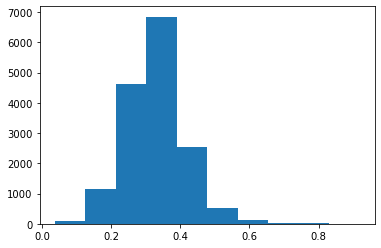

In [46]:
plt.hist(distances.values())

In [52]:
x = []
for i, distance in distances.items():
    if distance > 0.8:
        print(i)
        x.append(i)

10113
12921
12922
15123
15125
15126
15949


In [53]:
for atom in htf.hybrid_topology.atoms:
    if atom.index in x:
        print(atom)

MET455-HE1
LYS625-HE2
LYS625-HE3
2MA749-H62
2MA749-O6
2MA749-H6O
0YB783-H2M


In [39]:
solvent_indices = htf.hybrid_topology.select("resn HOH or resn 'Na+' or resn 'Cl-' or resn ZN or resn CL")